In [60]:

import json
import pandas as pd
import numpy as np
import math
import re
import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import import_ipynb
import download_acled 

# set some user parameters here
country_of_interest = ['Niger', 'Mali', 'Burkina Faso']
event_start_date = '2019-01-01'
num_clusters = 3


In [61]:
# call the acled download functions from the other file, download_acled.ipynb
acled_data = []
for country in country_of_interest:
    print( "getting data for country {}".format( country ))
    acled_params = download_acled.get_acled_download_parameters(country, event_start_date)
    acled_data += download_acled.download_acled_data(acled_params) 


getting data for country Niger
downloading acled page  1
success
number of results  500
downloading acled page  2
success
number of results  737
500
737
getting data for country Mali
downloading acled page  1
success
number of results  500
downloading acled page  2
success
number of results  1000
downloading acled page  3
success
number of results  1500
downloading acled page  4
success
number of results  1802
500
1000
1500
1802
getting data for country Burkina Faso
downloading acled page  1
success
number of results  500
downloading acled page  2
success
number of results  1000
downloading acled page  3
success
number of results  1500
downloading acled page  4
success
number of results  1595
500
1000
1500
1595


In [62]:
# convert it into an pandas data frame 
results_table = pd.DataFrame(acled_data)

# force typing of numerical data 
results_table = download_acled.recast_acled_numerical_columns( results_table )

In [63]:
# let's split them up by event_type to be generally useful
battles      = results_table[results_table.event_type == 'Battles']
remote_viols = results_table[results_table.event_type == 'Explosions/Remote violence']
viol_ag_civs = results_table[results_table.event_type == 'Violence against civilians']
riots        = results_table[results_table.event_type == 'Riots']
protests     = results_table[results_table.event_type == 'Protests']
strat_devs   = results_table[results_table.event_type == 'Strategic developments']


In [64]:
# let's try to arrange data into a table of events by terrorists
# could include battles, remote violence, and/or violence against civilians
bad_guys_events = pd.concat([battles, remote_viols, viol_ag_civs])

# set index and sort
bad_guys_events.set_index('data_id', inplace=True)
bad_guys_events.sort_values('data_id')
print( "rows: {}".format(len(bad_guys_events.index)))

# optional: print to excel file to double check our work
# bad_guys_events.to_excel("output.xlsx")


rows: 3031


In [65]:
# filter out, on actor1 (who caused the event), non-terrorists
# such as militias, police, military, and multinational joint task forces
# we'll also take out Unidentified groups so we can later compare clustering to attribution
filter_out_by = 'militia|Police|MNJTF|Military|Azawad|MINUSMA|G5|VDP|Dan na|GATIA|Ganda Izo|Unidentified'
bad_guys_events = bad_guys_events[~bad_guys_events['actor1'].str.contains(filter_out_by, flags=re.IGNORECASE)] 

print( bad_guys_events.actor1.unique() )

print( "rows: {}".format(len(bad_guys_events.index)))

['Islamic State (West Africa)'
 'JNIM: Group for Support of Islam and Muslims'
 'Boko Haram - Jamatu Ahli is-Sunnah lid-Dawatai wal-Jihad'
 'Islamic State (West Africa) and/or Boko Haram - Jamatu Ahli is-Sunnah lid-Dawatai wal-Jihad'
 'Islamic State (Greater Sahara)'
 'JNIM: Group for Support of Islam and Muslims and/or Islamic State (Greater Sahara)'
 'Katiba Macina' 'Islamic State (Greater Sahara) and/or Ansaroul Islam']
rows: 1693


In [66]:

# optional: filter by some numerical metric
# here, we can try to filter out boko/diffa stuff by using a longitudinal limit
bad_guys_events = bad_guys_events[bad_guys_events['longitude'] < 5.5] 

print( "rows: {}".format(len(bad_guys_events.index)))

rows: 1462


In [67]:
# let's look at clustering by geolocation

# first pull the lats and lons and reorganize into a 2-D array that KMeans requires
lats = bad_guys_events['latitude'].to_numpy().astype(np.float)  # get the lats as flots in numpy array
lons = bad_guys_events['longitude'].to_numpy().astype(np.float) # get the lons as flots in numpy array
lat_lons = np.vstack((lats, lons)).T                            # join them together in a shape that kmeans wants
kmeans = KMeans(n_clusters=num_clusters, init='k-means++').fit(lat_lons)   # run the kmeans algorithm

In [68]:
# let's get an array showing the determined cluster for each data point
cl_labels = kmeans.labels_
print(cl_labels)

[1 2 1 ... 1 1 1]


In [69]:
# let's get the k-means clustering centers
cl_centers = kmeans.cluster_centers_
print(cl_centers)

[[14.17456012 -3.64406518]
 [13.60786843 -0.38715494]
 [15.95893574  1.52434217]]


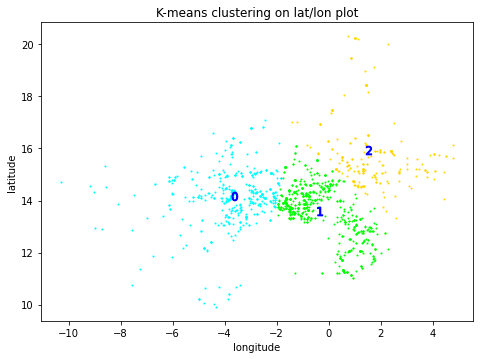

In [70]:
#let's plot this out on a lat/lon blank map to visualize how it did it's k-means clustering

# first, rearrange the data for use in scatter plotting
lat_lons_transposed = lat_lons.transpose()
#len(lat_lons_transposed[0])
#lat_lons_transposed

# open a matplotlib plotting figure and format the axes
fig = plt.figure()
fig.set_size_inches(6,6)
ax = fig.add_axes([0,0,1,1])
ax.set_aspect('equal') # fix the aspect ratio 
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.set_title('K-means clustering on lat/lon plot')

# plot data points with little dots in various colors
for i in range(len(lat_lons_transposed[0])):
    if cl_labels[i] == 0:
        cl_color = "aqua" #
    elif cl_labels[i] == 1:
        cl_color = "lime" #
    elif cl_labels[i] == 2:
        cl_color = "gold" #
    elif cl_labels[i] == 3:
        cl_color = "purple" #
    elif cl_labels[i] == 4:
        cl_color = "darkred" #
    else:
        cl_color = "orange" #

    y = lat_lons_transposed[0][i]
    x = lat_lons_transposed[1][i]

    ax.scatter(x, y, color=cl_color, s=1)

#plot centers with big blue stars
for i in range(len(cl_centers)):
    ax.scatter(cl_centers[i][1], cl_centers[i][0], marker="${}$".format(i), s=75, color="#0000FF") #blue

plt.show()



How well does geographic clustering correlate with attribution?  
In Niger, and most of West/Sahel Africa countries over the past couple of years, ACLED will use mostly standardized
group names as one of four groups: ISIS-WA, ISIS-GS, JNIM, and Boko Haram
In this case, there are some that are listed as ISIS-WA OR Boko, and also will attribute some attacks to both JNIM and ISIS-GS

In [71]:
# First, let's create the exact same type of matrix of clustering, but based on attributed group
group_Boko_Haram = '.*Boko Haram'
group_ISIS_WA = '(.*Islamic State)(.*West Africa)'
group_ISIS_GS = '(.*Islamic State)(.*Greater Sahara)'
group_JNIM = '.*JNIM'
group_MLF = '.*Macina'

#df = bad_guys_events.loc[(bad_guys_events['actor1'].str.contains(group_Boko_Haram, flags=re.IGNORECASE))] # & df['favorite_color']

BH_matrix = bad_guys_events['actor1'].str.contains(group_Boko_Haram, flags=re.IGNORECASE)
ISIS_WA_matrix = bad_guys_events['actor1'].str.contains(group_ISIS_WA, flags=re.IGNORECASE)
ISIS_GS_matrix = bad_guys_events['actor1'].str.contains(group_ISIS_GS, flags=re.IGNORECASE)
JNIM_matrix = bad_guys_events['actor1'].str.contains(group_JNIM, flags=re.IGNORECASE)
MLF_matrix = bad_guys_events['actor1'].str.contains(group_MLF, flags=re.IGNORECASE)

In [72]:
print( "BH     \n", BH_matrix.value_counts() )
print( "ISIS_WA\n", ISIS_WA_matrix.value_counts() )
print( "ISIS_GS\n", ISIS_GS_matrix.value_counts() )
print( "JNIM   \n", JNIM_matrix.value_counts() )
print( "JN+ISGS\n", (JNIM_matrix & ISIS_GS_matrix).value_counts() )
print( "MLF    \n", MLF_matrix.value_counts() )


BH     
 False    1462
Name: actor1, dtype: int64
ISIS_WA
 False    1462
Name: actor1, dtype: int64
ISIS_GS
 False    754
True     708
Name: actor1, dtype: int64
JNIM   
 True     1090
False     372
Name: actor1, dtype: int64
JN+ISGS
 False    1080
True      382
Name: actor1, dtype: int64
MLF    
 False    1416
True       46
Name: actor1, dtype: int64


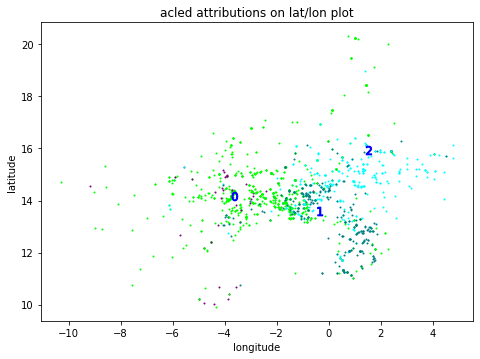

In [73]:

# open a matplotlib plotting figure and format the axes
fig2 = plt.figure()
fig2.set_size_inches(6,6)
ax = fig2.add_axes([0,0,1,1])
ax.set_aspect('equal') # fix the aspect ratio 
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.set_title('acled attributions on lat/lon plot')

# plot data points with little dots in various colors
for i in range(len(lat_lons_transposed[0])):
    if BH_matrix.iloc[i] and ISIS_WA_matrix.iloc[i]:
        cl_color = "orange" #   
    elif BH_matrix.iloc[i]:
        cl_color = "gold" #
    elif ISIS_WA_matrix.iloc[i]:
        cl_color = "red" #
    elif JNIM_matrix.iloc[i] and ISIS_GS_matrix.iloc[i]:
        cl_color = "teal" # 
    elif JNIM_matrix.iloc[i]:
        cl_color = "lime" #
    elif ISIS_GS_matrix.iloc[i]:
        cl_color = "aqua" #
    elif MLF_matrix.iloc[i]:
        cl_color = "purple" #
    else:
        cl_color = "black" # something went wrong

    ax.scatter(lat_lons_transposed[1][i], lat_lons_transposed[0][i], color=cl_color, s=1)

#plot centers with big blue numbers
for i in range(len(cl_centers)):
    ax.scatter(cl_centers[i][1], cl_centers[i][0], marker="${}$".format(i), s=75, color="#0000FF") #blue

plt.show()

So it looks like there is some, but not a strong, relationship between geo clusters and attributions.

How good is it? We can use the a Matthews’ Correlation Coefficient to give insight.  Since this is really
a binary comparison at heart, we'll take each group one at a time.


In [74]:
# we'll take each group's matrix, and for those that have two (and/or) attributions, 
# we'll use those as predicted in both cases

# first, let's figure out which cluster center is closest to each attributed group's geo clusters
# since we'll do this a few times, let's make a function   
def best_cluster_center(group_matrix, all_lats, all_lons, cluster_centers):

    # first lets get only those lat lons that correspond to the group in question
    group_lats = []
    group_lons = []
    for i in range(len(all_lats)):
        if group_matrix.iloc[i]:
            group_lats.append(all_lats[i])
            group_lons.append(all_lons[i])

    # then calc the mean
    lat_mean = pd.Series(group_lats).mean()
    lon_mean = pd.Series(group_lons).mean()

    # now let's get the distance to each cluster center
    distance = []
    for i in range(len(cl_centers)):
        d = math.sqrt( (lat_mean - cluster_centers[i][0])**2 + (lon_mean - cluster_centers[i][1])**2 ) 
        distance.append(d)

    # so which index is that?
    best_cluster_center = np.array(distance).argmin()

    return best_cluster_center

In [75]:

def find_matthews_corrcoeff_for_group(group_matrix, all_lats, all_lons, cluster_centers):
    y_true = group_matrix.to_numpy().astype(int)
    y_pred = []

    group_best_center_index = best_cluster_center(group_matrix, lats, lons, cl_centers)
    for i in range(len(cl_labels)):
        if cl_labels[i] == group_best_center_index:
            y_pred.append(1)
        else:
            y_pred.append(0)

    return group_best_center_index, matthews_corrcoef(y_true, y_pred)

In [76]:
print( "the cluster point and MCC for BOKO is   ", 
        find_matthews_corrcoeff_for_group(BH_matrix, lats, lons, cl_centers) )
print( "the cluster point and MCC for ISIS-WA is", 
        find_matthews_corrcoeff_for_group(ISIS_WA_matrix, lats, lons, cl_centers) )
print( "the cluster point and MCC for ISIS-GS is", 
        find_matthews_corrcoeff_for_group(ISIS_GS_matrix, lats, lons, cl_centers) )
print( "the cluster point and MCC for JNIM is   ", 
        find_matthews_corrcoeff_for_group(JNIM_matrix, lats, lons, cl_centers) )
print( "the cluster point and MCC for MLF is    ", 
        find_matthews_corrcoeff_for_group(MLF_matrix, lats, lons, cl_centers) )


the cluster point and MCC for BOKO is    (0, 0.0)
the cluster point and MCC for ISIS-WA is (0, 0.0)
the cluster point and MCC for ISIS-GS is (1, 0.3991877036539076)
the cluster point and MCC for JNIM is    (1, 0.06579885633592626)
the cluster point and MCC for MLF is     (0, 0.24401854903647263)


So really this doesn't work that well - multiple groups gravitated towards the same cluster centers, and correlations are pretty poor overall.